<h1>Data Preprocessing of Inflation Data</h1>

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox, probplot
import pylab
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
# Bringing the csv data file (Explored) into the notebook
df = pd.read_csv('../Data/Explored')
df.head()

,date,CPI
0,2022-09-02,12.7
1,2022-09-01,12.7
2,2022-08-31,12.7
3,2022-08-30,12.7
4,2022-08-29,12.7


In [26]:
# Converting date field to datetime
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,CPI
0,2022-09-02,12.7
1,2022-09-01,12.7
2,2022-08-31,12.7
3,2022-08-30,12.7
4,2022-08-29,12.7


In [27]:
# Setting the datetime as the index
df.set_index('date', inplace=True)

<AxesSubplot:xlabel='date'>

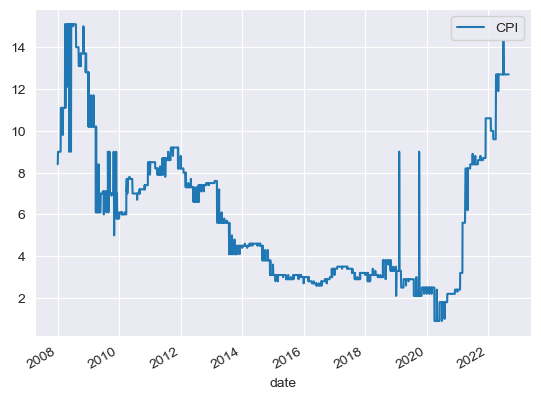

In [28]:
# Line plot of the time series data
df.plot()

The models that will be used do not support datetime values in the data, so the data is converted into integers for number of days since the first date which was in 2008.

In [29]:
# Converting date to number of days from the first date in 2008.
df.index = abs((df.index[3770] -  df.index).days)
df

,CPI
date,
5358,12.7
5357,12.7
5356,12.7
5355,12.7
5354,12.7
...,...
121,12.1
152,14.5
182,15.0


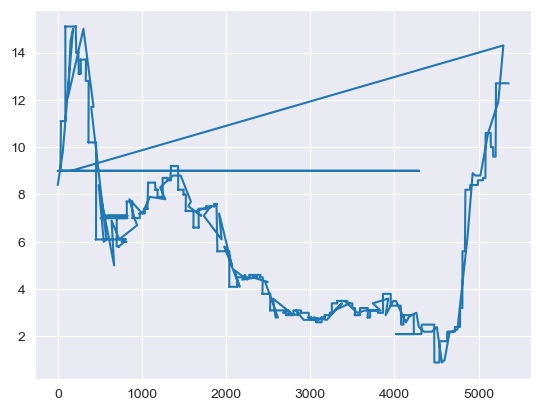

In [30]:
# A plot of the entries once datetime is replaced with number of days (integer)
plt.plot(df)

In [31]:
df.to_csv('../Data/PreprocessedNew')

<h4>Stationarity Assessment</h4>

Statistical modelling of time series data comes with an assumption that the data is stationary ie. That it does not depend on time (including having trend and seasonality components). In order to ensure that this is the case, the data must be decomposed into it's components of Trend, Seasonality, Noise, and Level (average). This way, the summary statistics (such as mean and variance) of the data remain constant regardless of time.

<h5>Consistency of Summary Statistics</h5

One quick way to observe this is to test for these summary statistics at various times and see if they change significantly.

In [32]:
#Checking for changes in summary statistics at various times in the data.
X = df.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=4.233103, mean2=7.578102
variance1=8.844411, variance2=9.110629


The mean does seem to have quite a big change which is to be expected. It is very clear that the data was relatively consistent only during the years of 2016 to 2022.

We can better understand the stationarity of the time series data using an Augmented Dickey-Fuller Test.

<h5>Augmented Dickey Fuller Test</h5>

Augmented Dickey-Fuller test is a unit root test that tests for how much a time series is defined by a trend. The null hypothesis is that the data is non-stationary while the alternate hypothesis is that the data is stationary.

In [33]:
#The augmented dickey fuller test
X = df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.419757
p-value: 0.136238
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


With a p-value of 0.14, it is pretty safe to say that the data is non-stationary and so it may be necessary to difference it in order to make it stationary.

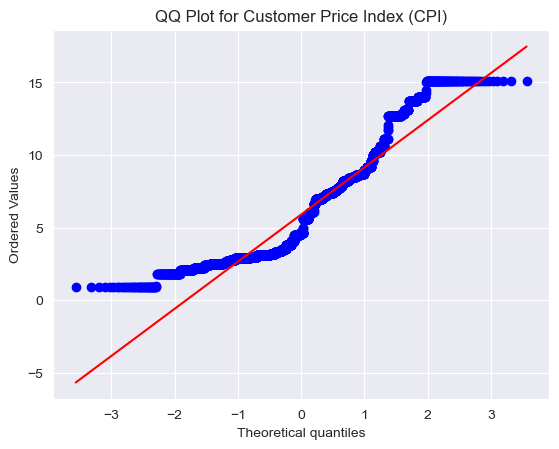

In [34]:

probplot(df['CPI'], plot=pylab)
plt.title('QQ Plot for Customer Price Index (CPI)')
pylab.show()

As can be clearly seen in the plot above, the data does not follow a normal distribution and models are likely not to perform optimally on the data.

<h4>Holt-Winters Exponential Smoothing</h4>

Holt-Winters Exponential Smoothing allows for predictions on time series data that is not stationary.

In [35]:
hw_model = ExponentialSmoothing(df['CPI'])
model_fit = hw_model.fit()

C:\Users\ituser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
yhat = model_fit.predict(1, len(df['CPI']))

C:\Users\ituser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


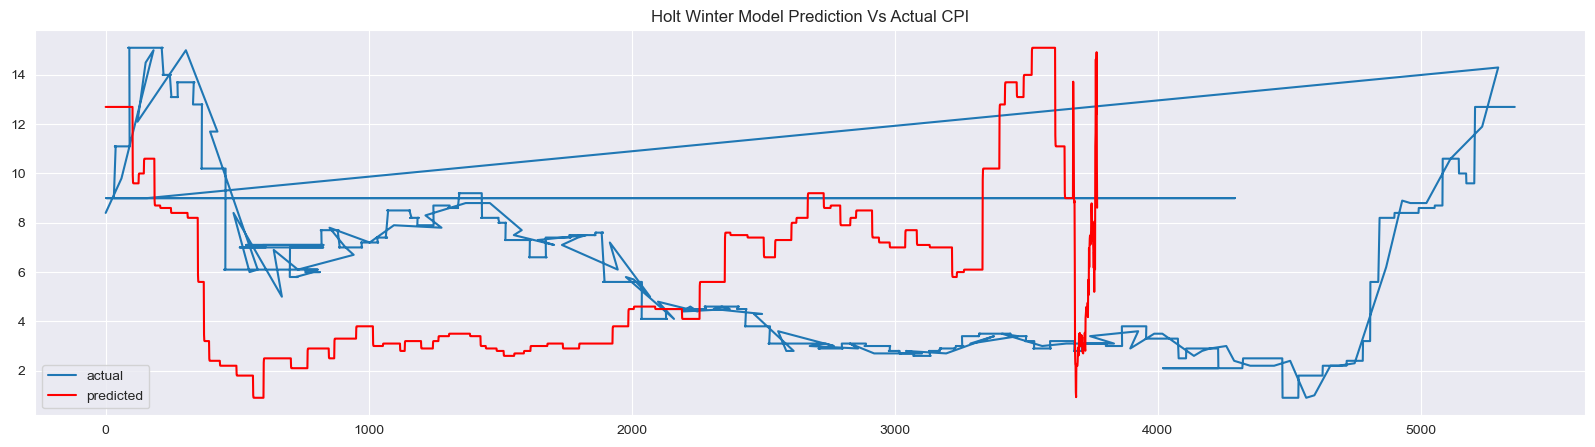

In [37]:
plt.figure(figsize=(20,5))
plt.plot(df['CPI'])
plt.plot(yhat.tolist(), color='red')
plt.title("Holt Winter Model Prediction Vs Actual CPI")
plt.legend(["actual", "predicted"])

plt.show()

The performance of the Holt-Winters Exponential Smoothing technique is not so great according to the plot above. Perhaps removing the stationarity from the data and using other models would yield better results.

<h4>Inducing Stationarity by Differencing</h4>

As mentioned above, it is important for the data to be stationary because this is a pre-requisite for many statistical and learning models. We will make the dataset stationary by differencing the data from its single step lag.

The lag scatter plot shown earlier in this notebook shows that there is a very high positive correlation between values and their one-step lags. Based on this, the differencing will be done based on the one step as well.

In [38]:
#Creating stationary version of the Dataset by Differencing
value = df - df.shift(1)
value.dropna(inplace=True)
value.head()

,CPI
date,
5357,0.0
5356,0.0
5355,0.0
5354,0.0
5351,0.0


In [39]:
#Testing for stationarity again using Augmented Dickey-Fuller Test

X = value.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, val in result[4].items():
    print('\t%s: %.3f' % (key, val))

ADF Statistic: -10.341134
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


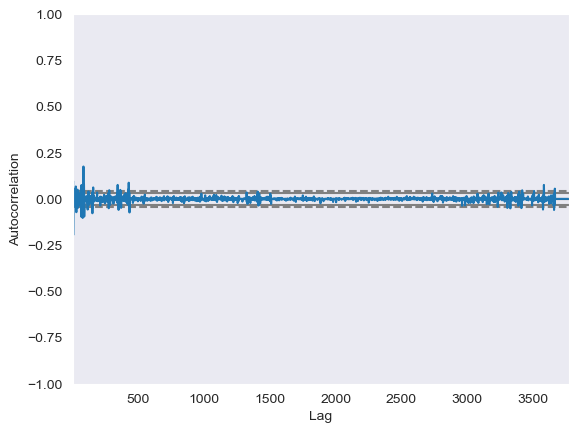

In [40]:
pd.plotting.autocorrelation_plot(value)
plt.show()

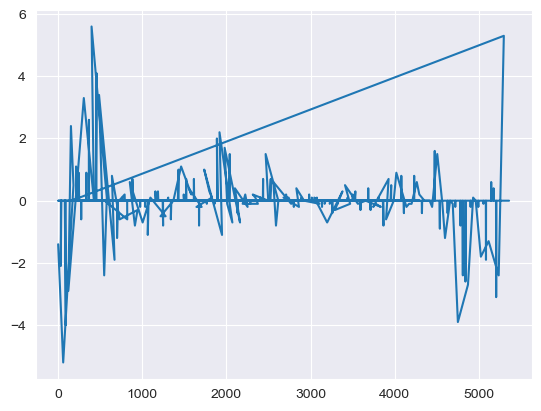

In [41]:
plt.plot(value)

After differencing, the p value of the test has dropped to far less than 5%. The dataset is now stationary and ready for modelling.

In [42]:
df.to_csv('../Data/StationaryLatest')

<h4>Data Power Transforms</h4>

Another important step to take before using a lot of statistical models is to ensure that the data has a normal distribution. A lot of statistical models assume this. As can be seen below, the data does not have a normal distribution. A solution to this is using Power Transforms.

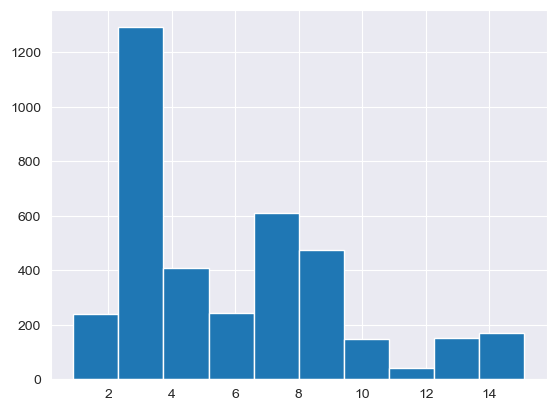

In [43]:
df['CPI'].hist()
plt.show()

As can be seen with the plot above, it is hard to tell what kind of trend the data exhibits which makes it difficult to decide what transformation would be best. Based on this, a Box-Cox Transform shall be used with lambda = None to see which transformation is most suitable.

In [44]:
df.values

array([[12.7],
       [12.7],
       [12.7],
       ...,
       [15. ],
       [ 9.8],
       [ 8.4]])

Lambda: 0.040575


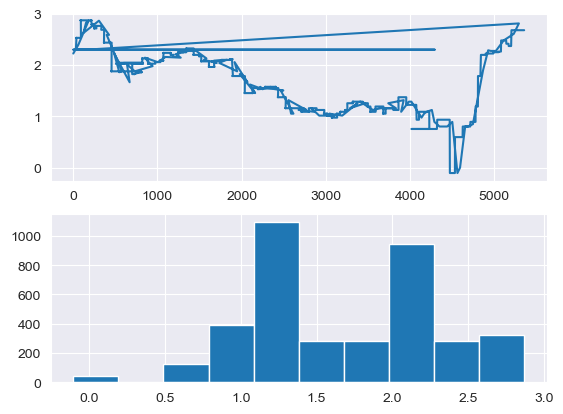

In [45]:
#dataframe = pd.DataFrame(df.values)
dataframe = df
dataframe.columns = ['CPI']
dataframe['CPI'], lam = boxcox(dataframe['CPI'])
print('Lambda: %f' % lam)

plt.figure(1)

plt.subplot(211)
plt.plot(dataframe['CPI'])

plt.subplot(212)
plt.hist(dataframe['CPI'])
plt.show()

With a lambda value of 0.041, this is very close to zero. Based on this, a log transform was performed on the data.

The transformed data will be kept and used during modelling as an alternative to see the performance compared to data that has not been transformed yet.

In [46]:
dataframe.to_csv('../Data/transformed')

<h4>Breaking data into Training, Validation and Test sets</h4>

In this section, the uni-variate data will be broken into training, validation and test sets. It is important to keep in mind that this is time series data and so the order of the data should be preserved in splitting it. SKLearn's TimeSeriesSplit function does this well.

The first step is to get the validation set which will be used during the process of hyperparameter tuning. About 10% of the data will be used for validation, we will use 365 records.

In [47]:
df.sort_values(by='date', inplace=True)
df.reset_index(inplace=True)
split_point = len(df) - 365
dataset, validation = df[0: split_point], df[split_point:]

In [48]:
validation

,date,CPI
3406,4831,1.784407
3407,4832,1.784407
3408,4833,1.784407
3409,4836,1.784407
3410,4837,1.784407
...,...,...
3766,5354,2.677278
3767,5355,2.677278
3768,5356,2.677278
3769,5357,2.677278


In [49]:
X = dataset['date']
y = dataset['CPI']

In [50]:
dataset

,date,CPI
0,0,2.222825
1,2,2.298146
2,3,2.298146
3,6,2.298146
4,7,2.298146
...,...,...
3401,4824,1.784407
3402,4825,1.784407
3403,4826,1.784407
3404,4829,1.784407


In [51]:
tscv = TimeSeriesSplit()

In [52]:
# Split data into train and test

for train_index, test_index in tscv.split(y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

At this point, the data has been split into validation, training and test data. The validation data will be used for hypertuning the models, while the test data will be used to evaluate the final models.